## Time Series Data: trend analysis and prediction

Time series data is a series of data points collected or recorded at specific time interval. These data points are typically ordered chronologically, allowing for analysis of patterns, trends, and behaviors over time. time series prediction presents its own challenges which are different from other machine-learning problems. We'll delve into some of the features and challenges in this project.  


In [1]:
import seaborn as sns
sns.set()

import datetime 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.fft

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler

In [4]:
# fetch the data
!aws s3 sync s3://dataincubator-course/mldata/ . --exclude '*' --include 'train.v2.csv.gz'

In [2]:
# create a dataframe from the dataset and retrieve the data information
df = pd.read_csv('train.v2.csv.gz', parse_dates=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392136 entries, 0 to 392135
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   station         392136 non-null  object
 1   time            392136 non-null  object
 2   temp            392136 non-null  object
 3   dew_point       392136 non-null  object
 4   pressure        392136 non-null  object
 5   wind_speed      392136 non-null  object
 6   wind_direction  392136 non-null  object
 7   precip_hour     392136 non-null  object
 8   weather_codes   392136 non-null  object
dtypes: object(9)
memory usage: 26.9+ MB
None


,station,time,temp,dew_point,pressure,wind_speed,wind_direction,precip_hour,weather_codes
0,PHX,2010-01-01 00:51,62.06,15.98,1024.90,3.00,20.00,M,M
1,PHX,2010-01-01 01:51,60.08,17.96,1025.30,4.00,50.00,M,M
2,PHX,2010-01-01 02:51,59.00,17.96,1025.60,4.00,30.00,M,M
3,PHX,2010-01-01 03:51,53.96,21.92,1026.00,0.00,0.00,M,M
4,PHX,2010-01-01 04:51,55.94,17.06,1026.20,5.00,40.00,M,M


The `station` column indicates the city.  The `time` is measured in UTC.  Both `temp` and `dew_point` are measured in degrees Fahrenheit.  The `wind_speed` is in knots, and the `precip_hour` measures the hourly precipitation in inches. Missing data is labelled with letter M. in this project, we will focus on using the temporal elements to predict temparature. 

For each question, build a model to predict the temperature in a given city at a given time. Return a collection of predicted temperatures, one for each incoming row in the DataFrame.  

### Q1: one-city model

Build a model to predict the temperature in a given city at given time. Return a collection of predicted temperatures, one for each incoming row in the dataframe. For this first question, we'll focus on only the data from New York (`"NYC"`).  

In [6]:
df.station.unique()

array(['PHX', 'SFO', 'PHNL', 'MSP', 'NYC'], dtype=object)

In [3]:
df_nyc = df[(df.station == 'NYC') & (df.temp != 'M')]
df_nyc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77745 entries, 314317 to 392135
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   station         77745 non-null  object
 1   time            77745 non-null  object
 2   temp            77745 non-null  object
 3   dew_point       77745 non-null  object
 4   pressure        77745 non-null  object
 5   wind_speed      77745 non-null  object
 6   wind_direction  77745 non-null  object
 7   precip_hour     77745 non-null  object
 8   weather_codes   77745 non-null  object
dtypes: object(9)
memory usage: 5.9+ MB


Seasonal features are nice because they are relatively safe to extrapolate into the future. There are two ways to handle seasonality.  

The simplest (and perhaps most robust) is to have a set of indicator variables. That is, make the assumption that the temperature at any given time is a function of only the month of the year and the hour of the day, and use that to predict the temperature value.

We'll apply Fast Fourier Transform (FFT)to extract the frequency components of the data. FFT is a method for analyzing the frequency components of a time-domain signal. It transforms a signal from its original domain (typically time or space) to a representation in the frequency domain. 

In [4]:
X = pd.to_datetime(df_nyc['time'])
y = pd.to_numeric(df_nyc['temp'])

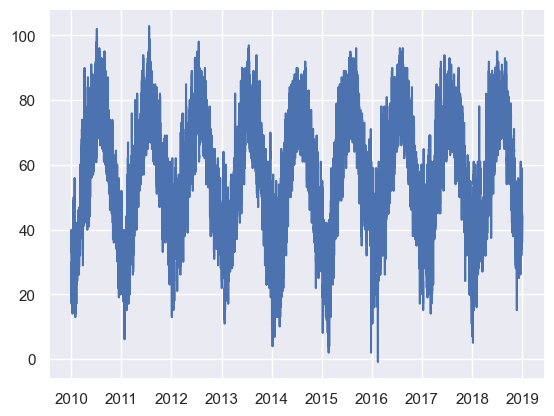

In [7]:
plt.plot(X, y);

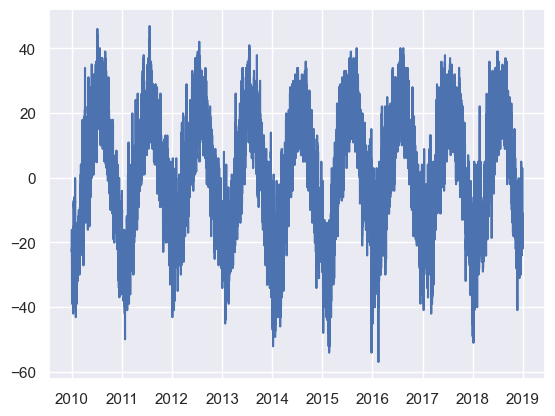

In [11]:
plt.plot(X, y-y.mean());

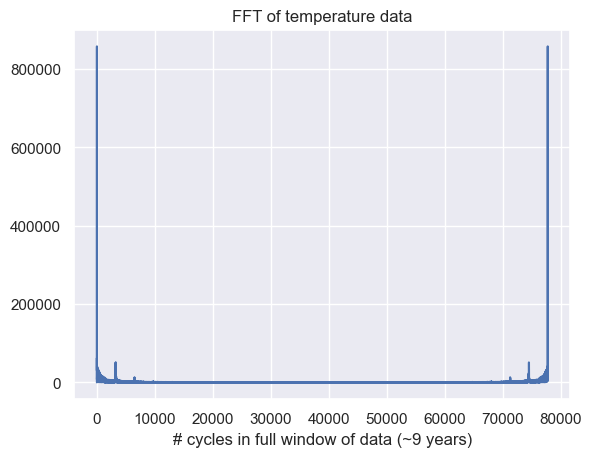

In [5]:
# Apply FFT transformation to the temperature data, and plot the magnitudes of the Fourier coefficients obtained from FFT
# Peaks indicate significant frequency components in the temperature data, and the corresponding x value represent the frequency components.
fft = scipy.fft.fft((y-y.mean()).values)
plt.plot(np.abs(fft))
plt.title('FFT of temperature data')
plt.xlabel('# cycles in full window of data (~9 years)');

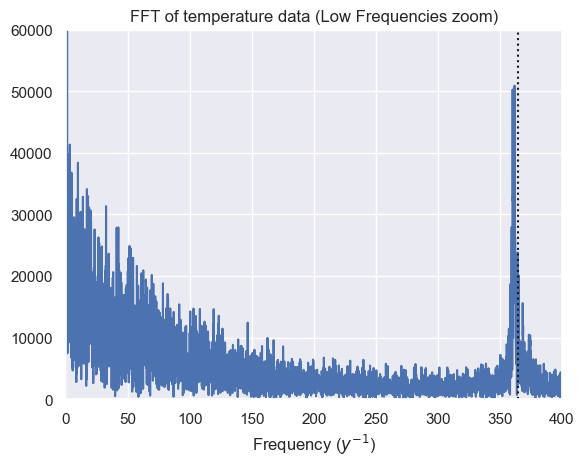

In [7]:
# adjust the axis range to reflect the annual frequency components
plt.plot(1./9 * np.arange(len(fft)), np.abs(fft))
plt.title("FFT of temperature data (Low Frequencies zoom)")
plt.axis([0,400, 0, 6e4])
plt.axvline(365, color='k', ls=':')
plt.xlabel('Frequency ($y^{-1}$)');

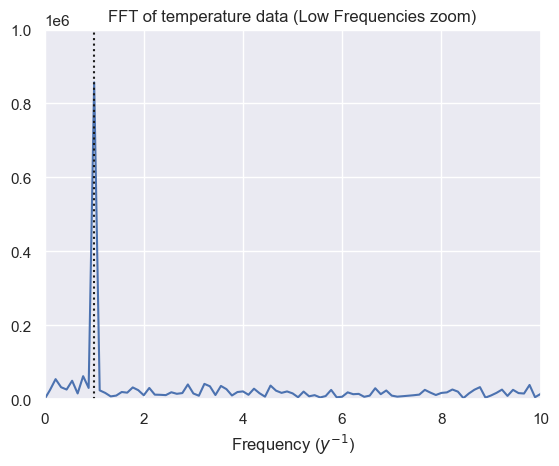

In [8]:
# adjust the axis range to reflect the daily frequency components
plt.plot(1./9 * np.arange(len(fft)), np.abs(fft))
plt.title("FFT of temperature data (Low Frequencies zoom)")
plt.axis([0,10, 0, 1e6])
plt.axvline(1, color='k', ls=':')
plt.xlabel('Frequency ($y^{-1}$)');

In [6]:
# create a customer transformer to transform a time series dataframe into its Fourier components of sinusoidal wave.
class FourierComponents(BaseEstimator, TransformerMixin):
    
    def __init__(self, period):
        self.period = period
        
    def fit(self, X, y=None):
        self.X0 = X.iloc[0] # saves the first timestamp 'X0' as reference timestamp
        return self
    
    def transform(self, X):
        dt = (X - self.X0).dt.days*2*np.pi/self.period # extract the number of days from the time difference, converted to radians, and scaled to represent a full circle of one period.
        return np.c_[np.sin(dt), np.cos(dt)] # create arrays containing the sine and cosine values of the angles, respectively.

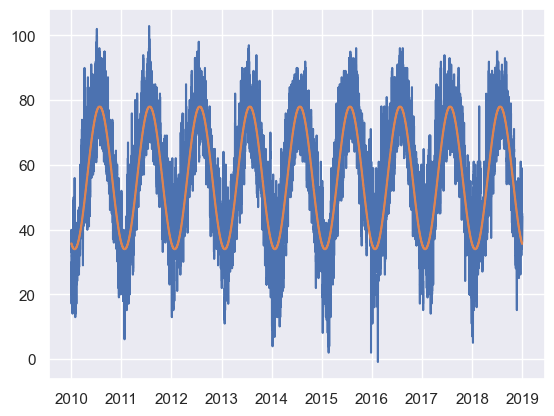

In [7]:
# assume the sine and cosine components are linearly related to temperature, apply LinearRegression to both and then make a prediction. 
pipe = Pipeline([('fourier', FourierComponents(365)),
               ('lr', LinearRegression())])
pipe.fit(X, y)

plt.plot(X, y, X, pipe.predict(X));

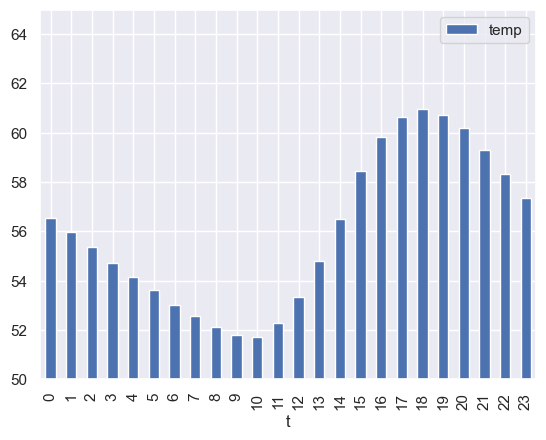

In [14]:
# create temperature dataframe at given hour of day, and extract the hourly temperature pattern.
df_hour = pd.DataFrame(
    {'t': X.dt.hour, 'temp': y}
)
df_hour.groupby('t').mean().plot(kind='bar')
plt.ylim([50, 65])
plt.xticks(range(24));

In [8]:
# create a transformer that transform a datetime feature into a one-hot encoded representation of hour of the day
class HourofDay(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    # transform the interger 'hour' to a one-hot encoded vector representing the given hour
    def hour_vector(self, hour):
        v = np.zeros(24)
        v[hour] = 1
        return v
    
    def transform(self, X):
        return np.stack([self.hour_vector(h) for h in X.dt.hour]) # creating two dimension array where each row reporesents the encoded hour of the day

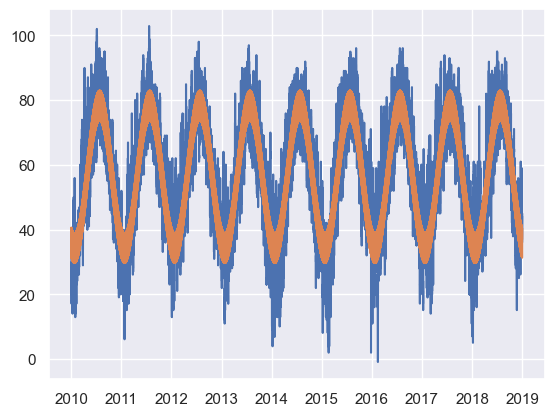

In [9]:
union = FeatureUnion([('fourier', FourierComponents(365)),
                     ('hourofday', HourofDay())])
pipe = Pipeline([('union', union),
                ('lr', LinearRegression())])

pipe.fit(X, y)
plt.plot(X, y, X, pipe.predict(X));

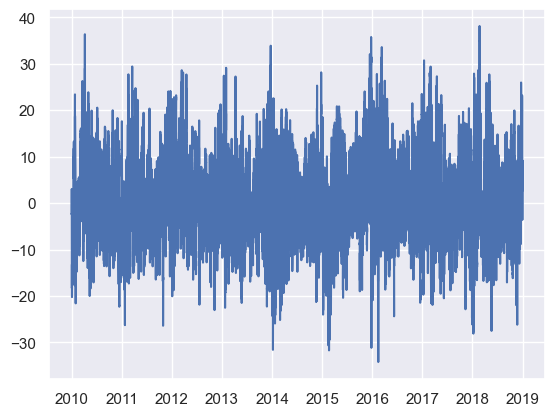

In [19]:
plt.plot(X, y-pipe.predict(X));

In [20]:
print('RMSE:', np.sqrt(metrics.mean_squared_error(y, pipe.predict(X))))
print('R^2:', metrics.r2_score(y, pipe.predict(X)))

RMSE: 8.185646385453495
R^2: 0.7906622955348332


In [11]:
# putting everything together
class DataConversion(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X): 
        return pd.to_datetime(X.time)

class FourierComponents(BaseEstimator, TransformerMixin):
    
    def __init__(self, period):
        self.period = period
        
    def fit(self, X, y=None):
        self.X0 = X.iloc[0]
        return self
    
    def transform(self, X):
        dt = (X - self.X0).dt.days*2*np.pi/self.period
        return np.c_[np.sin(dt), np.cos(dt)]

class HourofDay(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def hour_vector(self, hour):
        v = np.zeros(24)
        v[hour] = 1
        return v
    
    def transform(self, X):
        return np.stack([self.hour_vector(h) for h in X.dt.hour])

union = FeatureUnion([('fourier', FourierComponents(365)),
                     ('hourofday', HourofDay())])

In [12]:
nyc_model = Pipeline([('dc', DataConversion()),
                 ('union', union),
                ('lr', LinearRegression())])
X = df_nyc.drop(columns=['temp'])
y = pd.to_numeric(df_nyc['temp'])
nyc_model.fit(X, y).predict(X[:5])

array([36.2857666 , 35.66882324, 35.05419922, 34.45007324, 33.84460449])

### Q2: per-city model

Now we want to extend this same model to handle all of the cities in our data set.  Rather than adding features to the existing model to handle this, we'll just make a new copy of the model for each city. Make a **factory function** that returns a new copy of that Pipeline each time it's called.

In [13]:
# create a factory function that returns a new copy of that pipeline each time it's called.
def model_factory(city):
    city_model = Pipeline([('dc', DataConversion()),
                              ('union', union),
                              ('lr', LinearRegression())])
    return city_model # A single estimator or a pipeline

In [14]:
def city_dataframe(city):
    df_city = df[(df.station == city) & (df.temp != 'M')]
    return df_city

In [15]:
phx_model = model_factory('PHX')
X = city_dataframe('PHX').drop(columns=['temp'])
y = pd.to_numeric(city_dataframe('PHX')['temp'])
phx_model.fit(X, y).predict(X[:5])

array([65.31558228, 63.3944397 , 61.20178223, 59.12432861, 57.20199585])



While we could manually call this function for each city in our dataset, let's build a "group-by" estimator that does this for us.  This estimator should take a column name and a factory function as an argument.  The `fit` method will group the incoming data by that column, and for each group it will call the factory to create a new instance to be trained by on that group.  Then, the `predict` method will look up the corresponding model for each row and perform a prediction using that model. 

Please know when handling data in arbitrary order, we will nee to reorder the predictions to match the input order. A common way to do this is to attach the index of the feature matrix to the predictions, and then order the full prediction series by the index of the feature matrix.

In [16]:
pd.options.mode.copy_on_write = True #make a copy of the DataFrame when it is absolutely necessary.

In [33]:
# create a group-by estimator that create a new model for each group, and perform prediction for each row using the corresponding model.
class GroupbyEstimator(BaseEstimator, RegressorMixin):
    
    def __init__(self, station, model_factory):
        self.station = station
        self.model_factory = model_factory
        self.city_models = dict()
        # custom estimator to fit and predict using different models for each group.
    
    def fit(self, X, y=None):
        for city in X[self.station].unique():
            # extract data for the current group
            X_city = city_dataframe(city).drop(columns=['temp'])
            y_city = pd.to_numeric(city_dataframe(city)['temp'])

            # create a model for the current group using the provided factory model
            self.city_models[city] = self.model_factory(city)

            # fit the model to the data for the current group
            self.city_models[city].fit(X_city, y_city)
        return self
    
    def predict(self, X):
        result = np.zeros(X.shape[0])

        # create a new column for index in the original DataFrame
        X.loc[:, 'raw_idx'] = range(X.shape[0]) #create a new colum
        
        for city in X[self.station].unique():
            # extract data for the current group
            X_city = X[(X[self.station]==city)]

            #make predictions using the model for the current group
            X_city['y_pred'] = self.city_models[city].predict(X_city)

            # update the result array with predicted values for the current group
            result[X_city['raw_idx']] = X_city['y_pred']
        return result

In [34]:
city_model = GroupbyEstimator('station', model_factory)
city_model.fit(df, df['temp']).predict(df[:5])

array([65.31558228, 63.3944397 , 61.20178223, 59.12432861, 57.20199585])

### Q3: Fourier model

Let's consider another way to deal with the seasonal terms.  Since we know that temperature is roughly sinusoidal, we know that a reasonable model might be

$$ y_t = y_0 \sin\left(2\pi\frac{t - t_0}{T}\right) + \epsilon $$

where $y_0$ and $t_0$ are parameters to be learned and $T$ is the period - one year for seasonal variation, one day for daily, etc.  While this is linear in $y_0$, it is not linear in $t_0$. However, we know from Fourier analysis, that the above is
equivalent to

$$ y_t = A \sin\left(2\pi\frac{t}{T}\right) + B \cos\left(2\pi\frac{t}{T}\right) + \epsilon $$

which is linear in $A$ and $B$.

We will reate a model containing sinusoidal terms on one or more time scales, and fit it to the data using a linear regression.  We will also build a `fourier_factory` function that will return instances of this model.

In [21]:
# create a Fourier model containing sinusoidal terms on two time scales.
class DataConversion(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X): 
        return pd.to_datetime(X.time) # converted time column to datetime format
        
class FourierModel(BaseEstimator, TransformerMixin):
    
    def __init__(self, periods, n_harmonics):
        self.periods = periods
        self.n_harmonics = n_harmonics

    def fit(self, X, y=None):
        self.X0 = X.iloc[0]
        return self

    def transform(self, X):
        features = []
        for period in self.periods:
            for harmonic in range(1, self.n_harmonics + 1):
                dt = (X - self.X0).dt.days * 2.0 * np.pi * harmonic / period
                features.append(np.sin(dt))
                features.append(np.cos(dt))
        return np.column_stack(features)

def fourier_factory(periods, n_harmonics=1):
    fourier_model = Pipeline([
        ('dc', DataConversion()),
        ('fourier', FourierModel(periods=periods, n_harmonics=n_harmonics)),
        ('lr', LinearRegression())
    ])
    return fourier_model

In [26]:
# example usage
periods = [365]  # Assuming yearly seasonality
n_harmonics = 3     # Number of harmonics to include

# Create an instance of the fourier_model using fourier_factory
fourier_model = fourier_factory(periods, n_harmonics)

# Fit the model and make predictions
X = city_dataframe('PHX').drop(columns=['temp'])
y = pd.to_numeric(city_dataframe('PHX')['temp'])
fourier_model.fit(X, y).predict(X[:5])

array([54.74911878, 54.74911878, 54.74911878, 54.74911878, 54.74911878])